# Data Generation

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch

dim_theta = 10
data_num = 1000
scale = .1

theta_true = np.ones((dim_theta,1))
print('True theta:', theta_true.reshape(-1))

A = np.random.uniform(low=-1.0, high=1.0, size=(data_num,dim_theta))
y_data = np.matmul(A,theta_true)+np.random.normal(loc=0.0, scale=scale, size=(data_num,1))

A_test = np.random.uniform(low=-1.0, high=1.0, size=(50,dim_theta))
y_test = np.matmul(A_test,theta_true)+np.random.normal(loc=0.0, scale=scale, size=(50,1))

True theta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Solving for the exact mean squared loss (solving Ax = b)

In [2]:
theta_pred = (la.inv(A.T@A)@A.T).dot(y_data)
print('Empirical theta', theta_pred.reshape(-1))

Student needs to create theta_pred using A and y_data from above
Empirical theta [0.98960643 0.99140138 1.00326929 0.99881651 0.99642159 1.00214862
 0.99895275 0.99982499 1.00796883 1.00596594]


# SGD Variants Noisy Function

In [3]:
batch_size = 1
max_iter = 1000
lr = 0.001
theta_init = np.random.random((10,1)) * 0.1
theta_hat = np.ones((10,1))

In [4]:
# Noisy function that can be used in place of noisy_val_grad for the SGD variants (optional)
# def noisy_mse_val_grad(theta_hat, data_, label_, deg_=2.):
    # Atheta_minus_y_idx=np.matmul(data_,theta_hat) - label_
    # gradient = 2*np.matmul(np.transpose(data_), Atheta_minus_y_idx)
    # loss = np.sum(Atheta_minus_y_idx**2)
    # return loss / data_.shape[0],gradient / data_.shape[0]

def noisy_poly_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat, dtype=np.float64)
    loss = 0.0
    
    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = np.sum(x_ * theta_hat) - y_
        
#         print('Not implemented. Student needs to find the gradient and loss')
        if (x_.T @ theta_hat - y_) >= 0:
            grad = deg_ * (x_.T @ theta_hat - y_)**(deg_-1) * x_
        else:
            grad = -1 * deg_ * (y_ - x_.T @ theta_hat)**(deg_-1) * x_   
        l = np.abs(x_.T @ theta_hat - y_) ** deg_

        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]
    
    return loss, gradient

# Running SGD Variants

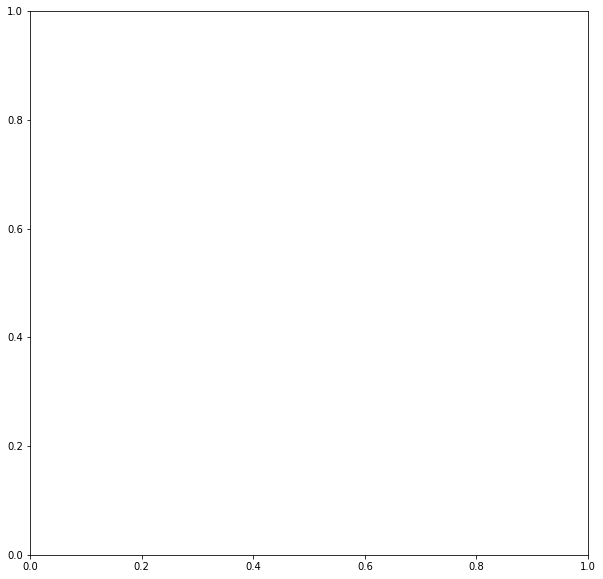

In [8]:
deg_ = 2
num_rep = 10
max_iter = 1000
fig, ax = plt.subplots(figsize=(10,10))
best_vals = dict()
test_exp_interval = 50
grad_artificial_normal_noise_scale = 0.

In [68]:
deg_

2

adam 0
adam done
final set of parameters:
 [0.12246955 0.18054023 0.16841918 0.14272902 0.13486938 0.20283009
 0.18790269 0.12909855 0.1560845  0.12175402]
sgd 0
sgd done
final set of parameters:
 [1.02119168 0.9035318  0.59927103 0.95466377 1.0069311  0.78915929
 0.85772652 0.75608772 0.97977756 0.89387667]
adagrad 0
adagrad done
final set of parameters:
 [0.78464722 0.67230525 0.85568904 0.75789574 0.67457839 0.80176955
 0.58531878 0.83904834 0.81230083 0.69161275]


Text(0.5, 0, 'Updates')

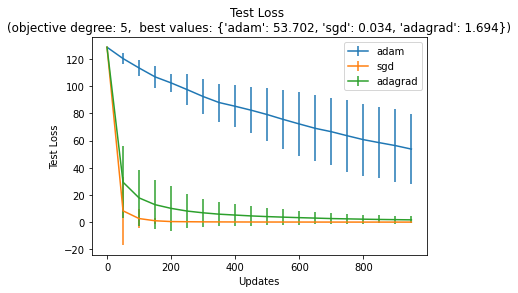

In [83]:
la_ada = 0.1
lr = 0.001
deg_ = 5
for method_idx, method in enumerate(['adam', 'sgd', 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []
    
    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)
            
        if method == 'adam':
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            m = 0
            nu = 0

        if method == 'adagrad':
            epsilon = 1e-8
            Gt = 0
#       Optional
#         if method == 'rmsprop':
#             print('This is not mandatory. Implement it for your own fun.')
#             print('Not implemented. Student has to initialize and create necessary hyperparameters/moments of RMSPROP')
#             ?????
            
        theta_hat = theta_init.copy()
        test_loss_list = []
        train_loss_list = []
        
        for t in range(max_iter):
            idx = np.random.choice(data_num,batch_size)
            train_loss, gradient = noisy_poly_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10,1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10,1))-0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)
            
            if t % test_exp_interval == 0:
                test_loss, _ = noisy_poly_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)                
            
            if method == 'adam':
                t_incremented = t + 1
                m = beta1 * m + (1-beta1) * gradient
                nu = beta2 * nu + (1-beta2) * gradient**2
                m_hat = m / (1 - beta1**t_incremented)
                nu_hat = nu / (1 - beta2**t_incremented)
                theta_hat = theta_hat - lr * m_hat / (np.sqrt(nu_hat) + epsilon)
            elif method == 'adagrad':
                if la_ada == -1:
                    la_ada = lr
                Gt += np.multiply(gradient, gradient)
                theta_hat = theta_hat - la_ada * (gradient / np.sqrt(Gt + epsilon))
            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient
                
#           Optional
#             elif method=='rmsprop':
#                 print('Not implemented. Student has to implement the core rmsprop algorithm (this is optional)')
#                 ????
#                 theta = theta - lr * ????

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)
        
    print(method, 'done')
    print("final set of parameters:\n", theta_hat[:,0])
    theta_final = theta_hat
    x_axis = np.arange(max_iter)[::test_exp_interval]
    
    test_loss_np = np.array(test_loss_mat)
    
#     print('Not implemented. Student has to create the test loss mean and the unbiased standard error vectors.')
#     print('test_loss_np is a 2d array with num_rep rows and some number of columns, where each column denotes a specific update stage in training.')
#     print('The elements of test_loss_np are the test loss values computed in each replicate and training stage.')
    test_loss_mean = np.mean(test_loss_np, axis = 0)
    test_loss_se = np.std(test_loss_np[:,:,0,0], axis = 0, ddof=1)
    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = {k: int(v*1000)/1000. for k,v in best_vals.items()} # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')

0.4 0
gamma = 0.4 done
final set of parameters:
 [0.1511235  0.18502067 0.20850988 0.21737219 0.11432643 0.15021151
 0.20792312 0.09552714 0.10814455 0.12401675]
0.7 0
gamma = 0.7 done
final set of parameters:
 [0.23785805 0.30973664 0.28014549 0.22427044 0.24644043 0.16902132
 0.25027131 0.24883907 0.25435438 0.17390131]
1 0
gamma = 1 done
final set of parameters:
 [0.34827662 0.37562259 0.36857951 0.28969107 0.32180952 0.26600343
 0.30879286 0.35374119 0.26180356 0.2716446 ]
2 0
gamma = 2 done
final set of parameters:
 [0.27732994 0.32786087 0.36311203 0.28711814 0.32885415 0.31277781
 0.3793785  0.35151724 0.29584584 0.31309208]
3 0
gamma = 3 done
final set of parameters:
 [0.26271728 0.31422638 0.25656045 0.26836025 0.27005024 0.2561269
 0.2914344  0.30903424 0.31182755 0.28936027]
5 0
gamma = 5 done
final set of parameters:
 [0.16391054 0.27385109 0.24707381 0.19632055 0.22876877 0.20780069
 0.2642649  0.18269218 0.23634536 0.22802817]


Text(0.5, 0, 'Updates')

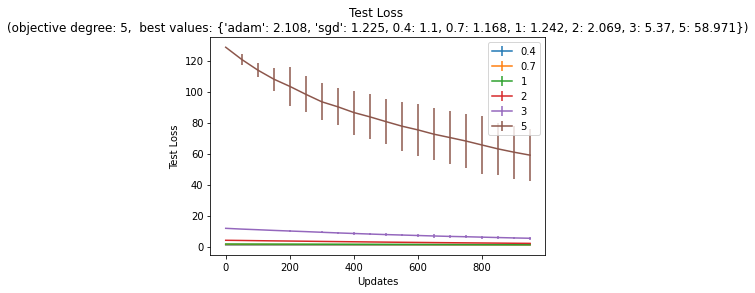

In [32]:
# Run ADAM under different gammas
lr = 0.001

for method_idx, degree in enumerate([0.4, 0.7, 1, 2, 3, 5]):
    test_loss_mat = []
    train_loss_mat = []
    
    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(degree, replicate)

        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        m = 0
        nu = 0

        theta_hat = theta_init.copy()
        test_loss_list = []
        train_loss_list = []
        
        for t in range(max_iter):
            idx = np.random.choice(data_num,batch_size)
            train_loss, gradient = noisy_poly_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=degree)
            artificial_grad_noise = np.random.randn(10,1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10,1))-0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)
            
            if t % test_exp_interval == 0:
                test_loss, _ = noisy_poly_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=degree)
                test_loss_list.append(test_loss)                
            
            t_incremented = t + 1
            m = beta1 * m + (1-beta1) * gradient
            nu = beta2 * nu + (1-beta2) * gradient**2
            m_hat = m / (1 - beta1**t_incremented)
            nu_hat = nu / (1 - beta2**t_incremented)
            theta_hat = theta_hat - lr * m_hat / (np.sqrt(nu_hat) + epsilon)

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)
        
    print('gamma =', degree, 'done')
    print("final set of parameters:\n", theta_hat[:,0])
    theta_final = theta_hat
    x_axis = np.arange(max_iter)[::test_exp_interval]
    
    test_loss_np = np.array(test_loss_mat)
    
    test_loss_mean = np.mean(test_loss_np, axis = 0)
    test_loss_se = np.std(test_loss_np[:,:,0,0], axis = 0, ddof=1)
    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=degree)
    best_vals[degree] = min(test_loss_mean)

best_vals = {k: int(v*1000)/1000. for k,v in best_vals.items()} # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {degree},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')

adam 0
adam done
final set of parameters:
 [0.04187839 0.1150596  0.10516021 0.06365549 0.05934639 0.06012718
 0.10786785 0.04888092 0.08552957 0.05759022]
sgd 0
sgd done
final set of parameters:
 [0.1883629  0.26167116 0.26596082 0.21543449 0.23629322 0.22929358
 0.28099314 0.21528629 0.25710452 0.20649727]


Text(0.5, 0, 'Updates')

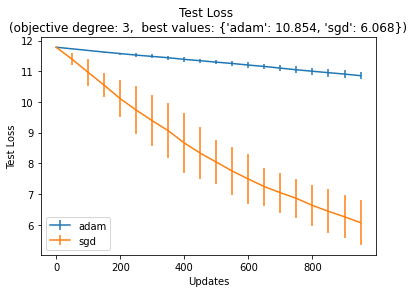

In [84]:
# Run ADAM and SGD under different gammas
la_ada = 0.1
lr = 0.0001
gamma = 3
num_rep = 10
best_vals = {}
max_iter = 1000
for method_idx, method in enumerate(['adam', 'sgd']):
    test_loss_mat = []
    train_loss_mat = []
    
    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)
            
        if method == 'adam':
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            m = 0
            nu = 0

        if method == 'adagrad':
            epsilon = 1e-8
            Gt = 0
            
        theta_hat = theta_init.copy()
        test_loss_list = []
        train_loss_list = []
        
        for t in range(max_iter):
            idx = np.random.choice(data_num,batch_size)
            train_loss, gradient = noisy_poly_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=gamma)
            artificial_grad_noise = np.random.randn(10,1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10,1))-0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)
            
            if t % test_exp_interval == 0:
                test_loss, _ = noisy_poly_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=gamma)
                test_loss_list.append(test_loss)                
            
            if method == 'adam':
                t_incremented = t + 1
                m = beta1 * m + (1-beta1) * gradient
                nu = beta2 * nu + (1-beta2) * gradient**2
                m_hat = m / (1 - beta1**t_incremented)
                nu_hat = nu / (1 - beta2**t_incremented)
                theta_hat = theta_hat - lr * m_hat / (np.sqrt(nu_hat) + epsilon)
            elif method == 'adagrad':
                if la_ada == -1:
                    la_ada = lr
                Gt += np.multiply(gradient, gradient)
                theta_hat = theta_hat - la_ada * (gradient / np.sqrt(Gt + epsilon))
            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)
        
    print(method, 'done')
    print("final set of parameters:\n", theta_hat[:,0])
    theta_final = theta_hat
    x_axis = np.arange(max_iter)[::test_exp_interval]
    
    test_loss_np = np.array(test_loss_mat)
    
    test_loss_mean = np.mean(test_loss_np, axis = 0)
    test_loss_se = np.std(test_loss_np[:,:,0,0], axis = 0, ddof=1)
    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = {k: int(v*1000)/1000. for k,v in best_vals.items()} # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {gamma},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')

adam 0
adam done
final set of parameters:
 [0.14188793 0.18667683 0.21640432 0.19224923 0.17763935 0.19828641
 0.22134331 0.1226359  0.19693465 0.14944562]
sgd 0
sgd done
final set of parameters:
 [0.7911831  0.86271988 0.8602081  0.77842364 1.01402424 0.95688021
 0.89445384 0.79913133 0.70305363 0.86893759]
adagrad 0
adagrad done
final set of parameters:
 [0.56362021 0.59700933 0.4933675  0.55602337 0.60995829 0.61591523
 0.35040439 0.45607385 0.4996217  0.65177727]


Text(0.5, 0, 'Updates')

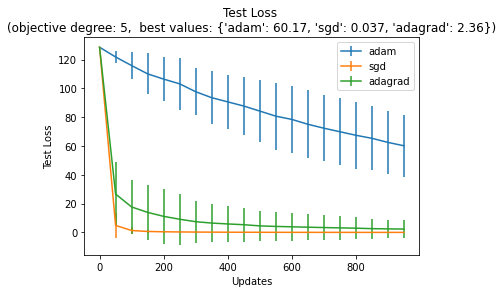

In [87]:
# Making ADAGRAD perform better than ADAM but worse than SGD
la_ada = 0.1
lr = 0.001
deg_ = 5
for method_idx, method in enumerate(['adam', 'sgd', 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []
    
    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)
            
        if method == 'adam':
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            m = 0
            nu = 0

        if method == 'adagrad':
            epsilon = 1e-8
            Gt = 0
#       Optional
#         if method == 'rmsprop':
#             print('This is not mandatory. Implement it for your own fun.')
#             print('Not implemented. Student has to initialize and create necessary hyperparameters/moments of RMSPROP')
#             ?????
            
        theta_hat = theta_init.copy()
        test_loss_list = []
        train_loss_list = []
        
        for t in range(max_iter):
            idx = np.random.choice(data_num,batch_size)
            train_loss, gradient = noisy_poly_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10,1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10,1))-0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)
            
            if t % test_exp_interval == 0:
                test_loss, _ = noisy_poly_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)                
            
            if method == 'adam':
                t_incremented = t + 1
                m = beta1 * m + (1-beta1) * gradient
                nu = beta2 * nu + (1-beta2) * gradient**2
                m_hat = m / (1 - beta1**t_incremented)
                nu_hat = nu / (1 - beta2**t_incremented)
                theta_hat = theta_hat - lr * m_hat / (np.sqrt(nu_hat) + epsilon)
            elif method == 'adagrad':
                if la_ada == -1:
                    la_ada = lr
                Gt += np.multiply(gradient, gradient)
                theta_hat = theta_hat - la_ada * (gradient / np.sqrt(Gt + epsilon))
            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient
                
#           Optional
#             elif method=='rmsprop':
#                 print('Not implemented. Student has to implement the core rmsprop algorithm (this is optional)')
#                 ????
#                 theta = theta - lr * ????

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)
        
    print(method, 'done')
    print("final set of parameters:\n", theta_hat[:,0])
    theta_final = theta_hat
    x_axis = np.arange(max_iter)[::test_exp_interval]
    
    test_loss_np = np.array(test_loss_mat)
    
#     print('Not implemented. Student has to create the test loss mean and the unbiased standard error vectors.')
#     print('test_loss_np is a 2d array with num_rep rows and some number of columns, where each column denotes a specific update stage in training.')
#     print('The elements of test_loss_np are the test loss values computed in each replicate and training stage.')
    test_loss_mean = np.mean(test_loss_np, axis = 0)
    test_loss_se = np.std(test_loss_np[:,:,0,0], axis = 0, ddof=1)
    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = {k: int(v*1000)/1000. for k,v in best_vals.items()} # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')